# Stock price forecasting system
Authors: Leonardo Emili, Alessio Luciani

## Project setup

In [1]:
try:
    # Setup the project directory if running on Colab
    from google.colab import drive
    !pip install -q wandb pytorch-lightning
    drive.mount('/content/gdrive/')
    !cp gdrive/MyDrive/stock-forecasting-proj/data.zip .
    !unzip -qo data.zip
    !rm -f data.zip
except:
    pass

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
%matplotlib inline

# Data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import missingno as msno
from sklearn.preprocessing import scale

# Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import pytorch_lightning as pl

pl.seed_everything(42)

# General
import glob
from tqdm.notebook import tqdm
from typing import *
import datetime

import wandb
from pytorch_lightning.loggers import WandbLogger
wandb.login()

Global seed set to 42
wandb: Currently logged in as: leonardoemili (use `wandb login --relogin` to force relogin)


## Dataset loading

In [3]:
# Key stats dataframe
key_stats_df = pd.read_csv("data/key_stats_yahoo.csv")
key_stats_df.drop(key_stats_df.columns[0], axis=1, inplace=True)
key_stats_df.Date = pd.to_datetime(key_stats_df.Date)

# Prices dataframes for every stock
prices_files = glob.glob("data/prices/*.csv")
dfs_names = [f.rsplit('/', 1)[1][:-len('.csv')] for f in prices_files]
prices_dfs = []
for f in tqdm(prices_files, desc='Reading stock price data', total=len(prices_files)):
    df = pd.read_csv(f)
    df.Date = pd.to_datetime(df.Date)
    prices_dfs.append(df)

## Dataset analysis

In [4]:
print("Key stats dataframe format:")
key_stats_df.head()

Key stats dataframe format:


,Date,Ticker,Price,DE Ratio,Trailing P/E,Price/Sales,Price/Book,Profit Margin,Operating Margin,Return on Assets,Return on Equity,Revenue Per Share,Market Cap,Enterprise Value,Forward P/E,PEG Ratio,Enterprise Value/Revenue,Enterprise Value/EBITDA,Revenue,Gross Profit,EBITDA,Net Income Avl to Common,Diluted EPS,Earnings Growth,Revenue Growth,Total Cash,Total Cash Per Share,Total Debt,Current Ratio,Book Value Per Share,Cash Flow,Beta
0,2004-01-30 19:01:00,a,33.8320,0.407,NaN,2.80,6.01,29.56,11.97,24.95,47.81,12.803,1.745000e+10,1.652000e+10,25.83,3.84,2.73,NaN,2.73,2.290000e+09,NaN,1.790000e+09,3.774,NaN,0.8,1.610000e+09,3.370,1.150000e+09,2.040,5.930,144000000.0,2.474
1,2004-04-13 04:07:00,a,28.4626,0.375,NaN,2.43,4.98,25.56,6.20,23.59,46.82,13.160,1.532000e+10,1.477000e+10,20.83,2.89,2.35,NaN,2.35,2.290000e+09,NaN,1.610000e+09,3.391,NaN,0.8,1.680000e+09,3.490,1.150000e+09,2.284,6.394,144000000.0,2.496
2,2004-12-13 21:37:00,a,21.8816,0.323,33.58,1.61,3.24,4.86,5.38,5.26,10.92,14.610,1.161000e+10,1.037000e+10,15.79,1.62,1.44,15.300,1.44,2.290000e+09,15.300,3.490000e+08,0.710,NaN,0.8,2.320000e+09,4.750,1.150000e+09,2.441,7.320,483000000.0,2.547
3,2005-01-22 05:17:00,a,20.2478,0.322,30.70,1.52,3.04,4.86,5.38,5.26,10.92,14.610,1.071000e+10,9.760000e+09,14.34,1.51,1.36,14.400,1.36,3.120000e+09,14.400,3.490000e+08,0.710,NaN,18.6,2.320000e+09,4.710,1.150000e+09,2.446,7.329,663000000.0,2.166
4,2006-01-09 02:35:00,a,31.7118,2.169,52.82,3.31,4.26,6.38,3.58,1.68,3.69,10.403,1.712000e+10,1.487000e+10,NaN,1.81,2.89,35.665,2.89,3.120000e+09,35.665,1.410000e+08,0.660,64.9,22.8,2.250000e+09,4.555,2.169000e+00,2.169,8.095,890000000.0,NaN


In [5]:
print("Prices dataframe format:")
prices_dfs[0].head()

Prices dataframe format:


,Date,Low,Open,Volume,High,Close,Adjusted Close
0,1973-03-05,18.458332,18.833332,116700,19.333332,19.083332,1.538000
1,1973-04-05,19.583332,19.583332,256800,19.958332,19.666668,1.585014
2,1973-07-05,19.541668,19.666668,55800,19.708332,19.583332,1.578297
3,1973-08-05,19.416668,19.583332,80100,19.583332,19.583332,1.578297
4,1973-09-05,19.541668,19.583332,66900,19.791668,19.666668,1.585014


### Utility functions

In [62]:
def prices_df_nan_summary(prices_dfs, names):
    ''' Utility function to summarize columns that have missing values. '''
    nan_dfs = []
    for i, (prices_df, name) in enumerate(zip(prices_dfs, names)):
        nan_cols = []
        nan_values = []
        for column in prices_df.columns:
            nan_absolute = prices_df[column].isnull().sum()
            if nan_absolute > 0:
                # Only consider columns that cointain NaN values
                nan_cols.append(column)
                nan_values.append(nan_absolute)
        if len(nan_cols):
            # Either we have all the data for a given day or we don't have any data for it
            assert len(set(nan_values)) == 1
            count = nan_values[0]
            nan_dfs.append((name, round(100*count/len(prices_df.index), 3), count))
    return pd.DataFrame(nan_dfs, columns=['Stock name', 'Missing data (%)', 'Count'])

def remove_trailing_nan(df: pd.DataFrame, ticker: str, col: str = 'Low') -> pd.DataFrame:
    '''
    A trick to detect if the input DataFrame ends with a contiguous collection of NaN rows.
    It is mainly an adaptation from: https://stackoverflow.com/questions/29007830/identifying-consecutive-nans-with-pandas
    '''
    if ticker == 'CTQ':
        # This special case refers to a stock that is not active for a long period but contains two days of activity:
        # up ..... up down ..... down [up down ... down up] down ..... down
        # We consider the period comprised in square brackets as an inactivity period. Otherwise feature imputation
        # would be harder and less reliable, hence dropping a few rows (i.e. 2) increases the quality of our data.
        df.iloc[1397] = np.nan
        df.iloc[1400] = np.nan
    group_by_nan = df[col].isnull().astype(int).groupby(df[col].notnull().astype(int).cumsum()).cumsum()
    training_nans = group_by_nan.iloc[-1]
    return df[:-training_nans] if training_nans > 0 else df

def merge_prices_fundamentals(
    prices_dfs: List[pd.DataFrame],
    key_stats_df: pd.DataFrame,
    dfs_names: List[str],
    drop_cols: List[str] = ['Date', 'Ticker', 'Price']
    ) -> List[pd.DataFrame]:

    # Define the target list of dataframes
    prices_dfs_new = []
    names_new = []
    for ticker, ticker_df in tqdm(key_stats_df.groupby('Ticker'), desc='Merging the datasets ...'):
        # Consider only stocks for which we have fundamental data
        if ticker.upper() not in dfs_names: continue

        # The current financial report
        ticker_iterator = list(ticker_df.iterrows())
        ticker_iter_idx = 0

        # Merge the two dataset according to the value of ticker_date
        ticker_row = ticker_iterator[ticker_iter_idx][1]
        ticker_date = ticker_row.Date
        ticker_row.drop(drop_cols, inplace=True)
        fundamental_cols, financial_values = ticker_row.index, ticker_row.values

        # Consider the relative stock ticker dataframe
        prices_df_idx = dfs_names.index(ticker.upper())
        prices_df = prices_dfs[prices_df_idx]
        # Dropping unused price value columns (we are using adjusted close)
        prices_df = prices_df.drop(['High', 'Low', 'Open', 'Close'], axis=1)
        fundamental_rows = []

        # Discard events that occurred before the first financial report
        begin_idx = prices_df[prices_df.Date >= ticker_date].index[0]
        for i, row in prices_df[begin_idx:].iterrows():
            # Use the last updated financial report if available (otherwise fast-forward the latest)
            if ticker_date < row.Date and ticker_iter_idx + 1 < len(ticker_iterator):
                # Update info about fundamental data
                ticker_iter_idx += 1
                ticker_row = ticker_iterator[ticker_iter_idx][1]
                ticker_date = ticker_row.Date
                ticker_row.drop(drop_cols, inplace=True)
                financial_values = ticker_row.values
            
            fundamental_rows.append(financial_values)

        # Finally merge the two datasets into one that has the same rows and the union of columns
        fundamental_df = pd.DataFrame(fundamental_rows, columns=fundamental_cols)
        valid_prices_df = prices_df[begin_idx:].reset_index(drop=True)
        merged_df = pd.concat((fundamental_df, valid_prices_df), axis=1)

        assert merged_df.shape == (fundamental_df.shape[0], fundamental_df.shape[1] + valid_prices_df.shape[1])
        prices_dfs_new.append(merged_df)
    
    return prices_dfs_new

def fill_missing_days(aggregate_dfs: List[pd.DataFrame], remove_weekends: bool = True, end_year: int = 2013) -> List[pd.DataFrame]:
    '''
    Returns the aggregated dataframes where gaps have been filled using fast-forward techniques.
    If remove_weekends is specified, only prices for weekdays are retained.
    '''

    def is_weekday(date: datetime) -> bool:
        ''' Returns true if the provided date corresponds to a weekday. '''
        return date.weekday() < 5

    result_dfs = []
    for df in tqdm(aggregate_dfs, desc='Filling missing days ...'):
        rows = list(df.iterrows())
        _, last_row = rows[0]
        
        # Skip datasets (less than 2%) whose available data starts after the end_year
        if end_year is not None and last_row.Date.year > end_year: continue
        date_idx = last_row.index.tolist().index("Date")

        output_rows = [last_row.values.tolist()]
        for _, row in rows[1:]:
            # Skip rows that exceed the end_year
            if end_year is not None and row.Date.year > end_year: break

            # Compute the current time gap in our dataset
            missing_days = (row.Date - last_row.Date).days - 1
            for day_offset in range(1, missing_days+1):
                # Fill the gap adding [day_offset] days with the last observed values
                delta = datetime.timedelta(days=day_offset)
                output_rows.append(last_row.values.tolist())
                output_rows[-1][date_idx] = last_row.Date + delta

            # Add and update the latest observed values
            output_rows.append(row.values.tolist())
            last_row = row
    
        # Skip weekends
        if remove_weekends:
            output_rows = [row for row in output_rows if is_weekday(row[date_idx])]
        result_dfs.append(pd.DataFrame(output_rows, columns=aggregate_dfs[0].columns))
    return result_dfs

def train_val_test_split(ds, train_size=0.75, val_size=0.15, test_size=0.10, seed=42):
    ''' Create random splits of the original [DataFrame], nmanually specify the seed for reproducible results. '''
    if train_size + val_size + test_size != 1:
        print('Input proportions do not sum up to 1! Using default values.', file=sys.stderr)
    n, m  = int(len(ds)*train_size), int(len(ds)*val_size)
    lengths = [n, m, len(ds)-n-m]
    return random_split(ds, lengths, generator=torch.Generator().manual_seed(seed))

def r2_score(y_hat: np.ndarray, y: np.ndarray) -> float:
    ''' Computes the R Squared coefficient between y_hat and y. '''
    rss = torch.sum((y - y_hat) ** 2)
    tss = torch.sum((y - y.mean()) ** 2)
    return 1 - rss / tss

#### Technical indicators

In [7]:
def add_sma(dfs: List[pd.DataFrame], period: int = 10) -> None:
    ''' Computes the Simple Moving Average from a given dataframe. '''
    for i in tqdm(range(len(dfs)), desc='Adding SMA ...'):
        ret = np.cumsum(dfs[i]["Adjusted Close"]).to_numpy()
        ret[period:] = ret[period:] - ret[:-period]
        sma = ret[period - 1:] / period
        missing_values = dfs[i].shape[0] - sma.shape[0]
        half_missing_values = missing_values//2
        sma_points = np.empty(dfs[i].shape[0], dtype=float)
        sma_points[half_missing_values:(half_missing_values)+sma.shape[0]] = sma
        sma_points[:half_missing_values] = dfs[i]["Adjusted Close"][:half_missing_values]
        sma_points[half_missing_values+sma.shape[0]:] = dfs[i]["Adjusted Close"][half_missing_values+sma.shape[0]:]
        dfs[i]["SMA"] = sma_points

def add_rsi(dfs: List[pd.DataFrame], period: int = 14) -> None:
    ''' Computes the Relative Strength Index from a given dataframe. 
        Formula available at https://en.wikipedia.org/wiki/Relative_strength_index.
        Also adds overbought and oversold when the RSI index hits 70 or 30.'''
    for j in tqdm(range(len(dfs)), desc='Adding RSI ...'):
        rsi_points = np.empty(dfs[j].shape[0], dtype=float)
        overbought_points = np.zeros(dfs[j].shape[0], dtype=float)
        oversold_points = np.zeros(dfs[j].shape[0], dtype=float)
        smmau = 0
        smmad = 0

        rsi_points[0] = 50
        for i in range(1, dfs[j].shape[0]):
            u = max(0, dfs[j]["Adjusted Close"][i] - dfs[j]["Adjusted Close"][i-1])
            d = max(0, dfs[j]["Adjusted Close"][i-1] - dfs[j]["Adjusted Close"][i])
            smmau = (smmau * (period - 1) + u) / period
            smmad = (smmad * (period - 1) + d) / period
            if smmad == 0 or smmau == 0:
                rsi_points[i] = 50
            else:    
                rs = smmau / smmad
                rsi = 100 - (100/(1+rs))
                rsi_points[i] = rsi
                if rsi >= 70: overbought_points[i] = 1
                if rsi <= 30: oversold_points[i] = 1
        
        dfs[j]["RSI"] = rsi_points
        dfs[j]["Overbought"] = overbought_points
        dfs[j]["Oversold"] = oversold_points

#### Feature scaling

In [8]:
def scale_features(dfs: List[pd.DataFrame]) -> None:
    ''' Scales the numerical features to unit variance. '''
    
    scalable_features = ['DE Ratio', 'Trailing P/E', 'Price/Sales', 'Price/Book',
       'Profit Margin', 'Operating Margin', 'Return on Assets',
       'Return on Equity', 'Revenue Per Share', 'Market Cap',
       'Enterprise Value', 'PEG Ratio', 'Enterprise Value/Revenue',
       'Enterprise Value/EBITDA', 'Revenue', 'Gross Profit', 'EBITDA',
       'Net Income Avl to Common ', 'Diluted EPS', 'Earnings Growth',
       'Revenue Growth', 'Total Cash', 'Total Cash Per Share', 'Total Debt',
       'Current Ratio', 'Book Value Per Share', 'Cash Flow', 'Beta', 'Volume',
       'Adjusted Close', 'SMA']

    aggregate_df = pd.concat(dfs)
    mean_vec = aggregate_df[scalable_features].mean()
    std_vec = aggregate_df[scalable_features].std()

    for i in tqdm(range(len(dfs)), desc='Scaling numerical features ...'):
        # Scaling scalable features
        dfs[i][scalable_features] = (dfs[i][scalable_features]-mean_vec)/std_vec
        # Scaling RSI between 0 and 1 to keep the relative information among different samples 
        dfs[i]["RSI"] = (dfs[i]["RSI"]/ 100)-0.5


### Missing values imputation

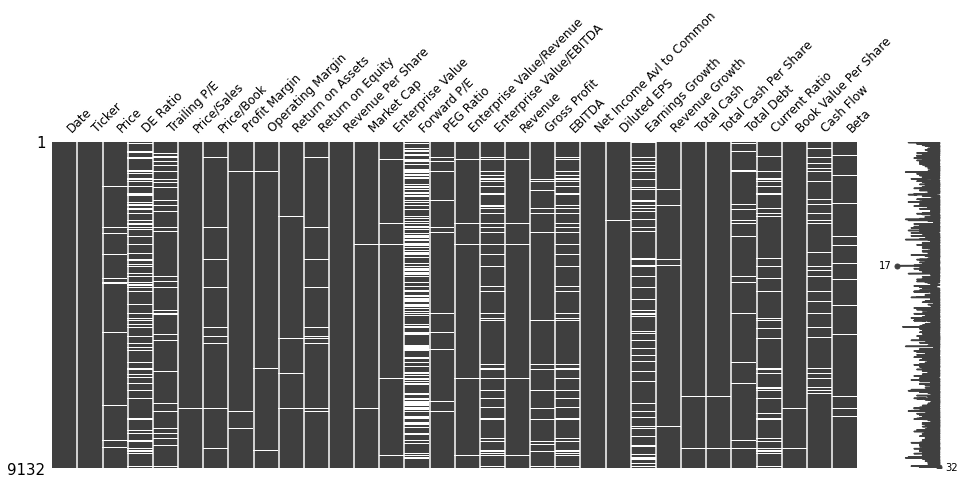

In [9]:
_ = msno.matrix(key_stats_df, figsize=(16,6), fontsize=12)

In [10]:
print("Overview of the missing values in the key_stats dataframe\n")
key_stats_summary = key_stats_df.isna().sum()           \
                        .sort_values(ascending=False)   \
                        .apply(lambda x: f"{round(100*x/len(key_stats_df.index), 3)}%")
key_stats_summary

Overview of the missing values in the key_stats dataframe



Forward P/E                  41.251%
DE Ratio                     16.886%
Earnings Growth              15.966%
Enterprise Value/EBITDA      10.633%
EBITDA                        10.37%
Current Ratio                 10.37%
Cash Flow                     9.801%
Trailing P/E                  8.432%
Beta                          4.413%
PEG Ratio                     4.325%
Gross Profit                   3.92%
Total Debt                    3.844%
Price                         3.657%
Return on Equity              3.011%
Return on Assets              2.508%
Price/Book                    2.354%
Revenue Growth                2.146%
Operating Margin              1.391%
Enterprise Value/Revenue      0.942%
Revenue                       0.909%
Total Cash                    0.854%
Enterprise Value              0.723%
Total Cash Per Share          0.712%
Profit Margin                 0.712%
Price/Sales                   0.548%
Book Value Per Share          0.449%
Diluted EPS                   0.296%
M

In [11]:
summary = prices_df_nan_summary(prices_dfs, dfs_names)
px.bar(summary, x='Stock name', y='Missing data (%)', hover_data=['Count'], title="Stock price dataset before preprocessing (only columns with missing values are displayed)")

For most of the above stocks with missing values, we noticed that they indeed exist up to a given time and after that no more data is available. It may due to a business failure, hence no more stocks will be exchanged from that moment on.

In [12]:
# Clear our input data from training NaN values
prices_dfs_new = [remove_trailing_nan(df,name) for df,name in zip(prices_dfs, dfs_names)]

# Remove INTH stock from our dataset since it contains many inactivity periods
inth_idx = dfs_names.index('INTH')
del dfs_names[inth_idx]
del prices_dfs_new[inth_idx]

summary = prices_df_nan_summary(prices_dfs_new, dfs_names)
px.bar(summary, x='Stock name', y='Missing data (%)', hover_data=['Count'], title="Stock price dataset after preprocessing (only columns with missing values are displayed)")

At this point we use the fast forward imputation technique to fill-in missing values. Please note that in this case missing values are mostly due to holidays or periods when stocks are not exchanged.

## Building the new dataset

In [13]:
# Impute missing values in the prices dataset (i.e. fast-forward last valid values)
prices_dfs_new = [df.fillna(method='ffill') for df in prices_dfs_new]
assert pd.concat(prices_dfs_new).isnull().sum().sum() == 0

# In this case this dataframe contains financial reports that may contain NaN values either because that
# metric was not available at that time OR because it was monitoring an initial stage of a company growth.
# What we do is to apply the classic fast-forward, and fill initial missing values with zeroes.
# Please note: we also discard the 'Forward P/E' column since the imputation here would introduce too much noise.
key_stats_df_new = key_stats_df.drop('Forward P/E', axis=1).fillna(method='ffill').fillna(0.)
assert key_stats_df_new.isnull().sum().sum() == 0

# Before merging the two datasets we need to sort them
prices_dfs_new = [df.sort_values(by=['Date']).reset_index(drop=True) for df in prices_dfs_new]
key_stats_df_new = key_stats_df_new.sort_values(by=['Date']).reset_index(drop=True)

# Merge the stock price dataset with fundamental data of the relative company
aggregate_dfs = merge_prices_fundamentals(prices_dfs_new, key_stats_df_new, dfs_names)
assert pd.concat(aggregate_dfs).isnull().sum().sum() == 0

# Fill gaps from the original dataset
dfs = fill_missing_days(aggregate_dfs)
assert pd.concat(dfs).isnull().sum().sum() == 0

# Add SMA indicator to each dataframe
add_sma(dfs)

# Add RSI indicator to each dataframe
add_rsi(dfs)

# Scale numerical features
scale_features(dfs)

## Hyperparameters
Here we define the list of hyperparameters that are used to define the shape of the dataset and models' behaviours.

In [54]:
hparams = {
    'input_dim': sliding_ds.shape[2],
    'window_size': sliding_ds.shape[1],
    'batch_size': 1024,
    'hidden_dim': 128,
    'num_layers': 1,
    'dropout': 0.5,
    'lr': 0.01
}

## Creating sliding window dataset

In [50]:
class SlidingWindowDataset(Dataset):
    '''
    A Dataset structure that shapes the input data according to the sliding window approach.
    Prices data consist of (x,y) window pairs of the following format:
        x: (window_size, feature_size)
        y: (1,target_cols)
    '''
    def __init__(
        self,
        prices: np.ndarray,
        indexes: np.ndarray,
        target_idx: int
        ) -> None:
        self.prices = prices
        self.indexes = indexes
        self.target_idx = target_idx

    @property
    def shape(self):
        return (self.indexes.shape[0], self.indexes.shape[1]-1, self.prices.shape[1])

    def __getitem__(self, index: int) -> Tuple[np.ndarray, np.ndarray]:
        x_idxs, y_idx = self.indexes[index, :-1], self.indexes[index, -1]
        return self.prices[x_idxs], self.prices[y_idx, self.target_idx]

    def __len__(self) -> int:
        return self.indexes.shape[0]

    def store(
        self,
        idx_path: str = 'data/preprocessed/indexes.npy',
        prices_path: str ='data/preprocessed/prices.npy'
        ) -> None:
        ''' Stores the collection of price values without the window size constraint, hence reducing output size. '''
        dir_path, _ = os.path.split(idx_path)
        os.makedirs(dir_path, exist_ok=True)
        dir_path, _ = os.path.split(prices_path)
        os.makedirs(dir_path, exist_ok=True)
        with open(idx_path, 'wb') as f1, open(prices_path, 'wb') as f2:
            np.save(f1, self.prices, allow_pickle=allow_pickle)
            np.save(f2, self.indexes, allow_pickle=allow_pickle)
    
    @classmethod
    def from_files(
        self,
        idx_path: str = 'data/preprocessed/indexes.npy',
        prices_path: str = 'data/preprocessed/prices.npy',
        target_col_idx: int = 30    # Index for adjusted close
        ) -> None:
        with open(idx_path, 'wb') as f1, open(prices_path, 'wb') as f2:
            prices = np.load(f1)
            indexes = np.load(f2)
        return cls(prices, indexes, target_col_idx)

    @classmethod
    def from_dfs(
        cls,
        dfs: List[pd.DataFrame],
        window_size: int = 20,
        target_col: str = 'Adjusted Close',
        **kwargs
        ):
        idx_stack = []
        # Use an offset value to avoid considering windows in the middle of two dataframes (i.e. synthetic data)
        offset = 0
        for df in tqdm(dfs, desc='Loading dataset from dataframes ...'):
            idx = offset + torch.arange(len(df)).unfold(0, window_size+1, 1)
            idx_stack.append(idx)
            offset += len(df)
        columns = dfs[0].columns.values
        target_col_idx = np.where(columns == target_col)[0]
        data = pd.concat([df.drop('Date', axis=1) for df in dfs]).to_numpy()
        return cls(data, torch.cat(idx_stack), target_col_idx)

class SlidingWindowDataModule(pl.LightningDataModule):
    def __init__(self, ds: SlidingWindowDataset, batch_size: int = 128):
        super().__init__()
        self.train_ds, self.val_ds, self.test_ds = train_val_test_split(ds, seed=42)
        self.batch_size = batch_size        

    def train_dataloader(self) -> DataLoader:
        return DataLoader(self.train_ds, batch_size=self.batch_size, drop_last=True, pin_memory=True, shuffle=True)
    
    def val_dataloader(self) -> DataLoader:
        return DataLoader(self.val_ds, batch_size=self.batch_size, drop_last=True, pin_memory=True)

    def test_dataloader(self) -> DataLoader:
        return DataLoader(self.test_ds, batch_size=self.batch_size, drop_last=True, pin_memory=True)

The dataset can be created either locally on your pc from the dataframes. You can do it calling the ````from_dfs```` method, or loading a preprocessed dataset calling the ```from_files``` method and specifying the required paths.

In [55]:
# Preprocess the dataset using DataFrames
sliding_ds = SlidingWindowDataset.from_dfs(dfs)

# Persist out the preprocessed dataset to reuse it later
#ds.store()

# Load preprocessed dataset from files
#ds = SlidingWindowDataset.from_files()

ds = SlidingWindowDataModule(sliding_ds, batch_size=hparams['batch_size'])

## Models definition

In [64]:
class SimpleLSTM(nn.Module):
    def __init__(self, hparams):
        super().__init__()
        self.hparams = hparams
        self.lstm = nn.LSTM(hparams.input_dim, hparams.hidden_dim, num_layers=hparams.num_layers, batch_first=True)
        self.fc1 = nn.Linear(hparams.hidden_dim, hparams.hidden_dim//2)
        self.fc2 = nn.Linear(hparams.hidden_dim//2, 1)
        self.dropout = nn.Dropout(hparams.dropout)

    def forward(self, x: np.ndarray):
        x, (h,c) = self.lstm(x)
        h = self.dropout(h)
        h = h.view(self.hparams.num_layers, -1, self.hparams.hidden_dim)[-1]
        x = torch.relu(self.fc1(h))
        x = self.fc2(x)
        return x

class StockPriceRegressor(pl.LightningModule):
    def __init__(self, hparams: Dict[str, any]):
        super().__init__()
        self.save_hyperparameters(hparams)
        self.loss_fn = nn.MSELoss()
        self.model = SimpleLSTM(self.hparams).double()

    def training_step(self, batch: Tuple[np.ndarray, np.ndarray], batch_idx: int):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss_fn(y_hat, y)
        return loss

    @torch.no_grad()
    def evaluation(self, batch: Tuple[np.ndarray, np.ndarray]) -> float:
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss_fn(y_hat, y)
        r2 = r2_score(y_hat, y)
        return loss, r2

    def validation_step(self, batch: Tuple[np.ndarray, np.ndarray], batch_idx: int) -> None:
        loss, r2 = self.evaluation(batch)
        metrics = {'val_loss': loss, 'val_r2': r2}
        self.log_dict(metrics)

    def test_step(self, batch: Tuple[np.ndarray, np.ndarray], batch_idx: int) -> None:
        loss, r2 = self.evaluation(batch)
        metrics = {'test_loss': loss, 'test_r2': r2}
        self.log_dict(metrics)

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.hparams.lr)

In [ ]:
run = wandb.init(reinit=True, project='spf')
model = StockPriceRegressor(hparams)
trainer = pl.Trainer(
    logger = WandbLogger(),
    log_every_n_steps = 1,
    gpus = 1 if torch.cuda.is_available() else 0,
    max_epochs = 50,
    deterministic=True
)
trainer.fit(model, ds)
trainer.test(model, ds.test_dataloader())
run.finish()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | model   | SimpleLSTM | 92.3 K
---------------------------------------
92.3 K    Trainable params
0         Non-trainable params
92.3 K    Total params
0.369     Total estimated model params size (MB)


Global seed set to 42


In [43]:
len(ds.train_dataloader())

463